# MACHINE LEARNING FINAL PROJECT


Students Info:
- Vũ Minh Chiến - 22127045
- Cao Nguyễn Huy Hoàng - 22127120

### **IMPORT LIBRARIES**

In [38]:
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
from sklearn import (tree, neural_network, metrics)
import tensorflow as tf
import seaborn as sns
from torch import(nn, optim, torch)
import os, sys, humanize, psutil, GPUtil

### **Data Preparation**

#### 1. Data collection

This dataset is collect from [cs.toronto.edu](https://www.cs.toronto.edu/~kriz/cifar.html). All files have been downloaded, unpacked and stored in `cifar-10-python` folder. The data will be stored in 5 variables with corresponding size:
- train_X (50000x3072)
- train_Y (50000x1)
- test_X (10000x3072)
- test_Y (10000x1)

The code below is used to read the data from the files as well as remove the redundant categorical features such as `batch-label` and `file-name`.

In [2]:
# function to read the pickle file
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict 


# define variables
test_X = test_Y = train_X = train_Y = None


# read batch file 1-5 to train_X and train_Y
for i in range(1, 6):
    # file name
    file = 'cifar-10-python/data_batch_' + str(i)

    # read data to a dictionary
    dict = unpickle(file)

    # convert data to numpy array and store to test_X and test_Y
    if train_X is None:
        train_X = np.array(dict['data'])
        train_Y = np.array(dict['labels']).reshape(-1, 1)
    else:
        train_X = np.concatenate((train_X, np.array(dict['data'])), axis=0)
        train_Y = np.concatenate((train_Y, np.array(dict['labels']).reshape(-1, 1)), axis=0)
# change train_Y to 1d
train_Y = train_Y.reshape(-1)

# read test_batch to test_X and test_Y
dict = unpickle('cifar-10-python/test_batch')
test_X = np.array(dict['data'])
test_Y = np.array(dict['labels']).reshape(-1)

#### 2. Data preprocessing

Find any missing value in the dataset

In [3]:
print(np.isnan(train_X).any(), np.isnan(train_Y).any(), np.isnan(test_X).any(), np.isnan(test_Y).any())

False False False False


So there aren't any missing values in this dataset.

Next is the normalization step, this is a image dataset so the values must be between [0, 255], but first let's check if this is right.

In [4]:
print(train_X.min(), train_X.max())

0 255


We have determined the values range is between [0, 255], now we can normalize it to range [0, 1]. This is a crucial step which can help promoting faster convergence during gradient-based training.

In [5]:
# this is shortern form of MinMax scaling
train_X = train_X / 255
test_X = test_X / 255

Applying one-hot for the label of the image. First we need to find the range of the label.

In [6]:
print(np.unique(train_Y))

[0 1 2 3 4 5 6 7 8 9]


Use a identity matrix to generate one-hot matrix

In [7]:
# create identity matrix with len = 10 (0-9)
eye_matrix = np.eye(10)

# generate one-hot
train_Y_one_hot = eye_matrix[train_Y.reshape(-1)]
test_Y_one_hot = eye_matrix[test_Y.reshape(-1)]

### **Define MLP Architecture:**
1. Number of layers: 2 hidden layers (128 and 64 neurons for the first and second layer, respectively).
2. Number of neurons per layer: 128 and 64 for first and second layer, respectively.
3. Activation function: ReLU for hidden layer and Softmax for outer layer.

### **Loss function and Optimizer:**
1. Loss function: Cross-entropy loss
2. Optimizer: Stochastic Gradient Descent (SGD)

In this section, the hardware I'm using is Nvida GeForce RTX 3050.

For `training time` we will use `%%time` function to get the right execute time of the training step, for `GPU Utilization` Nvida-smi+ extension which provided by Nvidia for visual studio code is use for mesuring. The `GPU memory usage` is mesure by `GPUtil` library.

### **Model Training**

1. Epochs: 100
2. Batch size: 32
3. Early stopping: If the loss doesn't improve at least 0.001 after 3 epochs

In [8]:
# function to calculate gpu usage
def mem_report():  
    GPUs = GPUtil.getGPUs()
    for i, gpu in enumerate(GPUs):
        print(f'GPU usage: {round(gpu.memoryUtil * 100, 2)}%')

- Sklearn

In [9]:
model_sklearn = neural_network.MLPClassifier(
    hidden_layer_sizes=(128, 64),   # Two hidden layers: 128 and 64 neurons
    activation='relu',              # Activation function for hidden layers
    solver='sgd',                   # Optimizer
    learning_rate_init=0.01,        # Initial learning rate
    max_iter=100,                   # Number of epochs
    batch_size=32,                  # Training progress
    early_stopping = True,          # early stopping
    n_iter_no_change = 3,           # max epoch for early stopping
    tol=0.001,                      # threshold for early stopping
    verbose=True                    #print result out
)
# Apply softmax for outer layer
model_sklearn.out_activation_ = 'softmax'

In [ ]:
%%time
# use sklearn to learn
model_sklearn.fit(train_X, train_Y)

# mesure gpu usage
mem_report()

Iteration 1, loss = 1.84495126
Validation score: 0.371000
Iteration 2, loss = 1.69593540
Validation score: 0.390800
Iteration 3, loss = 1.63876863
Validation score: 0.397400
Iteration 4, loss = 1.59903140
Validation score: 0.406600
Iteration 5, loss = 1.57063036
Validation score: 0.450800
Iteration 6, loss = 1.54300721
Validation score: 0.450600
Iteration 7, loss = 1.52657675
Validation score: 0.466600
Iteration 8, loss = 1.50718695
Validation score: 0.461400
Iteration 9, loss = 1.49308032
Validation score: 0.469000
Iteration 10, loss = 1.47799592
Validation score: 0.458200
Iteration 11, loss = 1.46457406
Validation score: 0.452400
Iteration 12, loss = 1.44873064
Validation score: 0.446800
Iteration 13, loss = 1.43611122
Validation score: 0.458600
Validation score did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
GPU usage: 1.93%
CPU times: total: 5min 46s
Wall time: 1min 56s


- Runtime: 2min 26s
- Highest GPU Utilization: 50%, most of the time is over 20%
- Max GPU Memory usage: 2%

Now use the model to predict the label for test set

In [29]:
pred_y_sklearn = model_sklearn.predict(test_X)

- Pytorch

In [11]:
class MLPClassifier_pytorch(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier_pytorch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128), # First hidden layer with 128 neurons and input size
            nn.ReLU(),                  # Activation function for first layer
            nn.Linear(128, 64),         # Second hidden layer with 64 neurons
            nn.ReLU(),                  # Activation function for the second layer
            nn.Linear(64, num_classes), # Output layer
            nn.Softmax(dim=1)           # Softmax for multi-class classification probabilities
        )
        self.double()
    
    def forward(self, x):
        return self.model(x) # Forward pass
    
# define early stopping class
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

model_pytorch = MLPClassifier_pytorch(input_size=3072, num_classes=10)

loss_pytorch = nn.CrossEntropyLoss() #Loss
optimizer_pytorch = optim.SGD(model_pytorch.parameters(), lr=0.01) #Optimizer

# definde early stopping para
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

In [ ]:
%%time
# convert to tensor
train_X_tensor = torch.from_numpy(train_X)

# iter through each epoch
for epoch in range(100):
    # inter through each batch
    for batch_ind in range(int(len(train_X) / 32)):
        # get x, y batch
        batch_x = train_X_tensor[batch_ind * 32 : batch_ind * 32 + 32]
        batch_y = train_Y[batch_ind * 32 : batch_ind * 32 + 32]

        # learn with batch_x
        ouput = model_pytorch(batch_x)

        # loss
        loss = loss_pytorch(ouput, torch.from_numpy(batch_y))

        # update sgd
        optimizer_pytorch.zero_grad()
        loss.backward()
        optimizer_pytorch.step()

    pre_y = model_pytorch(train_X_tensor)
    # calculate loss
    loss = loss_pytorch(pre_y, torch.from_numpy(train_Y))

    print(f'Epoch: {epoch} --- Loss: {loss}')

    if early_stopper.early_stop(loss):             
        print(f'Early stopping at epoch {epoch}')

mem_report()

Epoch: 0 --- Loss: 2.2894453668622234
Epoch: 1 --- Loss: 2.249114124219503
Epoch: 2 --- Loss: 2.221730715057603
Epoch: 3 --- Loss: 2.205647584187024
Epoch: 4 --- Loss: 2.1917250536998014
Epoch: 5 --- Loss: 2.1759748127729397
Epoch: 6 --- Loss: 2.1602896424024407
Epoch: 7 --- Loss: 2.1487416873579677
Epoch: 8 --- Loss: 2.1402451090517274
Epoch: 9 --- Loss: 2.1334801059076396
Epoch: 10 --- Loss: 2.1278157658888195
Epoch: 11 --- Loss: 2.1231476228240354
Epoch: 12 --- Loss: 2.1191080565041718
Epoch: 13 --- Loss: 2.115639179947842
Epoch: 14 --- Loss: 2.1126245206514294
Epoch: 15 --- Loss: 2.109950702246986
Epoch: 16 --- Loss: 2.107455299769278
Epoch: 17 --- Loss: 2.105206052196661
Epoch: 18 --- Loss: 2.103084002744465
Epoch: 19 --- Loss: 2.1012476214444824
Epoch: 20 --- Loss: 2.0997002071907818
Epoch: 21 --- Loss: 2.098268519523938
Epoch: 22 --- Loss: 2.096962963402353
Epoch: 23 --- Loss: 2.0953574992311976
Epoch: 24 --- Loss: 2.093604647010051
Epoch: 25 --- Loss: 2.091952587295973
Epoch: 2

https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch
- Runtime: 7min 14s
- Highest GPU Utilization: 47%, most of the time is around 10% - 15%, for the last 25 epoch 35%
- Max GPU Memory usage: 3%

Now use the model to predict the label for test set

In [30]:
pred_y_torch = None
with torch.no_grad():
    pred_y_torch = np.argmax(torch.Tensor.numpy(model_pytorch(torch.from_numpy(test_X))), axis=1)

- Tensorflow

In [13]:
Dense = tf.keras.layers.Dense
Softmax = tf.keras.layers.Softmax
ReLU = tf.keras.layers.ReLU

SGD = tf.keras.optimizers.SGD

model_tensor = tf.keras.Sequential([
    Dense(128, input_shape=(3072, )),  # First hidden layer with 128 neurons and input size
    ReLU(),                           # Activation function for the first layer 
    Dense(64),                        # Second hidden layer with 64 neurons
    ReLU(),                           # Activation function for the second layer 
    Dense(10),                        # Output layer
    Softmax()                         # Softmax for multi-class classification probabilities
])

model_tensor.compile(optimizer=SGD(learning_rate=0.01), #Optimizer 
              loss='categorical_crossentropy',          #Loss
              metrics=['accuracy'])                     #Accuracy for evaluation

earlytopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, verbose=1)

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
%%time
model_tensor.fit(train_X, train_Y_one_hot, batch_size=32, epochs=100)

# mesure gpu usage
mem_report()

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2673 - loss: 2.0204
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3782 - loss: 1.7319
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4106 - loss: 1.6473
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4404 - loss: 1.5800
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4542 - loss: 1.5436
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4645 - loss: 1.5079
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4737 - loss: 1.4871
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4820 - loss: 1.4633
Epoch 9/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4883 - loss: 1.4310
Epoch 10/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4990 - loss: 1.4043
Epoch 11/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5065 - loss: 1.3861
Epoch 12/100
1563/1

- Runtime: 8min 21s
- Highest GPU Utilization: 44%, for the firs 50 epochs most of the time is 12%, from 50 higer mostly 22%
- Max GPU Memory usage: 3.37%

Now use the model to predict the label for test set

In [37]:
pred_y_tensor = np.argmax(model_tensor.predict(test_X), axis=1)

pred_y_tensor

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(10000,)

### **Model Evaluation**

Accuracy of sklearn: 45.96%
Precesion =  0.66
Recall = 0.44
Specificity = 0.59
F1 Score = 0.53


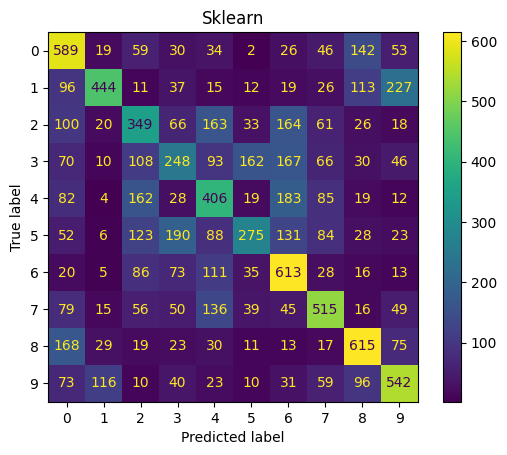

In [50]:
# get the confusion matrix
confusion = metrics.confusion_matrix(test_Y, pred_y_sklearn)


# display the matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
disp.ax_.set_title("Sklearn");

# accuracy
print(f'Accuracy of sklearn: {round(metrics.accuracy_score(test_Y, pred_y_sklearn) * 100, 2)}%')

# Precision
precesion =confusion[1, 1] / np.sum(confusion[:, 1])
print("Precesion = ", round(precesion, 2))

# recall
recall = confusion[1, 1] / np.sum(confusion[1, :])
print(f'Recall = {round(recall, 2)}')

# Specificity
print(f'Specificity = {round(confusion[0, 0] / np.sum(confusion[0, :]), 2)}')

# f1-score
print(f'F1 Score = {round(2 * precesion * recall / (precesion + recall), 2)}')

Accuracy of torch: 41.65%
Precesion =  0.54
Recall = 0.59
Specificity = 0.74
F1 Score = 0.57


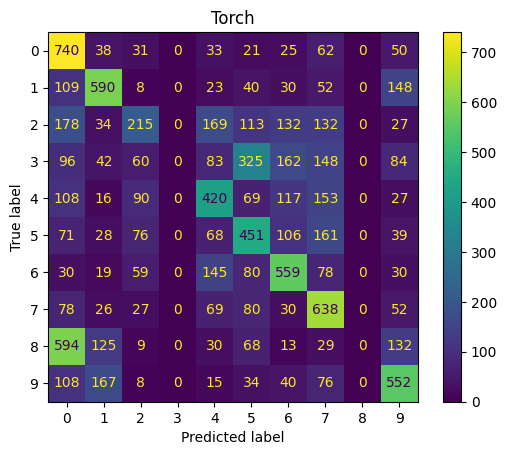

In [51]:
# get the confusion matrix
confusion = metrics.confusion_matrix(test_Y, pred_y_torch)


# display the matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
disp.ax_.set_title("Torch");

# accuracy
print(f'Accuracy of torch: {round(metrics.accuracy_score(test_Y, pred_y_torch) * 100, 2)}%')

# Precision
precesion =confusion[1, 1] / np.sum(confusion[:, 1])
print("Precesion = ", round(precesion, 2))

# recall
recall = confusion[1, 1] / np.sum(confusion[1, :])
print(f'Recall = {round(recall, 2)}')

# Specificity
print(f'Specificity = {round(confusion[0, 0] / np.sum(confusion[0, :]), 2)}')

# f1-score
print(f'F1 Score = {round(2 * precesion * recall / (precesion + recall), 2)}')

Accuracy of tensorflow: 47.91%
Precesion =  0.65
Recall = 0.53
Specificity = 0.55
F1 Score = 0.58


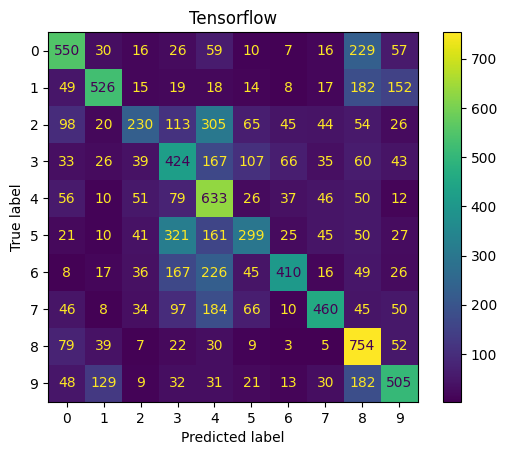

In [52]:
# get the confusion matrix
confusion = metrics.confusion_matrix(test_Y, pred_y_tensor)


# display the matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
disp.ax_.set_title("Tensorflow");

# accuracy
print(f'Accuracy of tensorflow: {round(metrics.accuracy_score(test_Y, pred_y_tensor) * 100, 2)}%')

# Precision
precesion =confusion[1, 1] / np.sum(confusion[:, 1])
print("Precesion = ", round(precesion, 2))

# recall
recall = confusion[1, 1] / np.sum(confusion[1, :])
print(f'Recall = {round(recall, 2)}')

# Specificity
print(f'Specificity = {round(confusion[0, 0] / np.sum(confusion[0, :]), 2)}')

# f1-score
print(f'F1 Score = {round(2 * precesion * recall / (precesion + recall), 2)}')

### **Reference**

- Sklearn model: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
 
- Pytorch neural network: https://pytorch.org/docs/stable/nn.html

- Pytorch optimization: https://pytorch.org/docs/stable/optim.html

- Early stopping in Pytorch: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

- Tensorflow model: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

- Tensorflow layers: https://www.tensorflow.org/api_docs/python/tf/keras/layers

- Tensorflow optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers